In [1]:
import pandas as pd
import numpy as np

In [2]:
IncludeMilitary = True
FloatRound = 2

In [3]:
Domains = ["Agriculture","Human Survival","Natural Disaster","Geography"]
if IncludeMilitary:
    Domains.append("Military")

In [4]:
def tokenizer(sent):
    return sent.split()

In [5]:
from spacy.lang.en import English
nlp = English()
nlp.Defaults.stop_words |= {"want","wish","know","learn"}

def dropStopWords(text):
    my_doc = nlp(text)
    return [word for token in my_doc if not (nlp.vocab[(word:=token.text)].is_stop or token.is_punct)]

In [6]:
df_qa = pd.read_csv("merged_answer_annotation.csv")
if not IncludeMilitary:
    df_qa = df_qa[df_qa["domain"] != "Military"]

## video & question count

In [7]:
def count_v_q(df,domain):
    df = df[df["domain"]==domain]
    return len(set(df['video_link'])),len(df)

In [8]:
for d in Domains:
    print(d,": ",count_v_q(df_qa,d))
print("Total:",len(set(df_qa['video_link'])),len(df_qa))

Agriculture :  (85, 109)
Human Survival :  (95, 309)
Natural Disaster :  (70, 187)
Geography :  (46, 110)
Military :  (73, 201)
Total: 369 916


## Table info

In [9]:
def mstd(arr):
    return np.round(np.mean(arr),FloatRound),np.round(np.std(arr),FloatRound)

### Phase 1

In [10]:
# annotation time
# annotation time
import os
import json

csv_files = []
for fn in [raw_file for raw_file in os.listdir("../organize_phase1_annotaton/raw_batches/") if raw_file.endswith(".csv")]:
    if not IncludeMilitary and fn.startswith("mil"): # don't show military information
        continue
    csv_files.append(
        pd.read_csv(f"../organize_phase1_annotaton/raw_batches/{fn}",converters={"Answer.taskAnswers": json.loads}))

if len(csv_files) > 0:
    phase1_anno_result = pd.concat(csv_files,join="inner")
    print(round(sum(phase1_anno_result['WorkTimeInSeconds'])/3600,2))

77.05


In [11]:
# video length
mstd(df_qa["duration"])

(71.22, 26.47)

In [12]:
# question per video
mstd(list(pd.value_counts(df_qa["video_link"])))

(2.48, 1.38)

In [13]:
# question length
mstd(df_qa["modified_question"].apply(lambda x:len(tokenizer(x))))

(7.09, 2.6)

In [14]:
# answer length
mstd(df_qa["modified_answer"].apply(lambda x:len(tokenizer(x))))

(8.62, 8.9)

In [15]:
# evidence per answer
mstd(df_qa["evidences"].apply(eval).apply(len))

(1.53, 0.76)

In [16]:
# evidence length
mstd([b for a in list(df_qa["evidences"].apply(eval).\
    apply(lambda x: [list(i.values())[0] for i in x]).\
    apply(lambda x: [i[1]-i[0] for i in x]))
    for b in a])

(9.09, 13.45)

### Phase 2

In [17]:
# annotated questions
print("crowd:",sum(df_qa["crowd_workerids"] != "[]"))
print("expert:",sum(df_qa["expert_workerids"] != "[]"))
print("total:",sum((df_qa["expert_workerids"] != "[]") | (df_qa["crowd_workerids"] != "[]")))

crowd: 914
expert: 104
total: 914


In [18]:
# annotated answers
print("crowd:",
      cas:=len([a for w in df_qa[df_qa["crowd_answers"] != "[]"]
           ["crowd_answers"] for ans in eval(w) for a in ans]))

print("expert:",
      eas:=len([a for w in df_qa[df_qa["expert_answers"] != "[]"]
           ["expert_answers"] for ans in eval(w) for a in ans]))
print("total:",cas+eas)

crowd: 933
expert: 182
total: 1115


In [19]:
# answer per question
mstd(df_qa.apply(
    lambda x: len([b for a in eval(x['crowd_answers']) for b in a])+\
    len([b for a in eval(x['expert_answers']) for b in a]),axis=1))

(1.22, 0.69)

In [20]:
# answer length
mstd([j for i in df_qa.apply(
    lambda x: [len(tokenizer(b)) for a in eval(x['crowd_answers']) for b in a]+\
    [len(tokenizer(b)) for a in eval(x['expert_answers']) for b in a],axis=1) for j in i])

(9.45, 7.45)

In [21]:
# Evidence per answer
mstd([b for a in df_qa["crowd_evidences"].apply(lambda x: [len(ans) for worker in eval(x) for ans in worker])
 for b in a] +\
[b for a in df_qa["expert_evidences"].apply(lambda x: [len(ans) for worker in eval(x) for ans in worker])
 for b in a])

(0.89, 0.72)

In [22]:
# Evidence length
mstd([evd[1]-evd[0] for evds in df_qa["crowd_evidences"] 
 for worker in eval(evds) for ans in worker for evd in ans] +\
[evd[1]-evd[0] for evds in df_qa["expert_evidences"] 
 for worker in eval(evds) for ans in worker for evd in ans])

(10.43, 5.81)

In [23]:
# annotation time
file_path = "../organize_phase2_annotation/"

total_time = 0

for annotator in ["expert","crowd"]:
    raw_files = os.listdir(f"{file_path}/{annotator}_raw_batches")
    csv_files = []
    for fn in [raw_file for raw_file in raw_files if raw_file.endswith(".csv")]:
        if not IncludeMilitary and fn.startswith("mil"): # don't show military information
            continue
        new_df = pd.read_csv(f"{file_path}/{annotator}_raw_batches/{fn}",converters={"Answer.taskAnswers": json.loads})
        # fix some early annotation stage issue
        if "Input.StdAnswer1" in new_df.columns:
            new_df.rename({f"Input.StdAnswer{i}":f"Input.stdAnswer{i}" for i in range(1,6)},
                          inplace=True,axis=1)
        if "Input.StdEviden1" in new_df.columns:
            new_df.rename({f"Input.StdEviden{i}":f"Input.stdEvidences{i}" for i in range(1,6)},
                          inplace=True,axis=1)
        for kk in range(1,6):
            new_df[f"Input.file{kk}"] = fn
        csv_files.append(new_df)
    if len(csv_files) == 0:
        continue
    anno_result = pd.concat(csv_files,join="inner")
    total_time += sum(anno_result['WorkTimeInSeconds'])
round(total_time/3600,2)

479.76

### combine phase

In [24]:
# answer length

mstd(list(df_qa["modified_answer"].apply(lambda x:len(tokenizer(x))))+\
[j for i in df_qa.apply(
    lambda x: [len(tokenizer(b)) for a in eval(x['crowd_answers']) for b in a]+\
    [len(tokenizer(b)) for a in eval(x['expert_answers']) for b in a],axis=1) for j in i])

(9.07, 8.15)

In [25]:
# evidence per answer
mstd(list(df_qa["evidences"].apply(eval).apply(len))+\
[b for a in df_qa["crowd_evidences"].apply(lambda x: [len(ans) for worker in eval(x) for ans in worker])
 for b in a] +\
[b for a in df_qa["expert_evidences"].apply(lambda x: [len(ans) for worker in eval(x) for ans in worker])
 for b in a])

(1.18, 0.8)

In [26]:
# evidence length
mstd([b for a in list(df_qa["evidences"].apply(eval).\
apply(lambda x: [list(i.values())[0] for i in x]).\
apply(lambda x: [i[1]-i[0] for i in x]))
for b in a]+\
[evd[1]-evd[0] for evds in df_qa["crowd_evidences"] 
 for worker in eval(evds) for ans in worker for evd in ans] +\
[evd[1]-evd[0] for evds in df_qa["expert_evidences"] 
 for worker in eval(evds) for ans in worker for evd in ans])

(9.64, 10.96)

## Objective analysis

In [27]:
# most common objective tokens
domain_most_obj_words = {}
for d in Domains:
    words_count = pd.value_counts(
        [b for a in df_qa[df_qa["domain"]==d]["objective"].apply(dropStopWords) for b in a])
    words_count.sort_values(ascending=False)
    domain_most_obj_words[d]={k:v for (k,v) in zip(words_count[:3].index,words_count[:3])}
domain_most_obj_words

{'Agriculture': {'farm': 15, 'Maintaining': 7, 'understand': 7},
 'Human Survival': {'man': 112, 'Determine': 87, 'human': 65},
 'Natural Disaster': {'Weather': 63, 'People': 33, 'Flooding': 14},
 'Geography': {'People': 28, 'Topography': 19, 'Water': 15},
 'Military': {'military': 25, 'aircraft': 22, 'Determine': 17}}

In [28]:
# most common objective tokens used times
for d in Domains:
    scount = 0
    for s in df_qa[df_qa["domain"]==d]["objective"]:
        for t in tokenizer(s):
            if t in domain_most_obj_words[d]:
                scount += 1
                break
    print(d,round(scount/len(df_qa),4))
del domain_most_obj_words, scount

Agriculture 0.0186
Human Survival 0.2063
Natural Disaster 0.1201
Geography 0.0633
Military 0.0524


## Question Analysis

In [29]:
# question base on for each domain
pd.value_counts(df_qa["question_base"])/len(df_qa)

['scene']             0.815502
['audio', 'scene']    0.112445
['audio']             0.072052
Name: question_base, dtype: float64

In [30]:
# question base on for each domain
for d in Domains:
    print(d,"\n",pd.value_counts(
        df_qa[df_qa["domain"]==d]["question_base"])/len(df_qa[df_qa["domain"]==d]),"\n")

Agriculture 
 ['audio']             0.376147
['audio', 'scene']    0.321101
['scene']             0.302752
Name: question_base, dtype: float64 

Human Survival 
 ['scene']             0.870550
['audio', 'scene']    0.097087
['audio']             0.032362
Name: question_base, dtype: float64 

Natural Disaster 
 ['scene']             0.967914
['audio', 'scene']    0.032086
Name: question_base, dtype: float64 

Geography 
 ['scene']             0.936364
['audio', 'scene']    0.063636
Name: question_base, dtype: float64 

Military 
 ['scene']             0.800995
['audio', 'scene']    0.124378
['audio']             0.074627
Name: question_base, dtype: float64 



### question type

In [31]:
question_type = round(pd.value_counts([b for a in df_qa["question_type"] for b in eval(a)]) / len(df_qa)*100,2)

In [32]:
question_type.index=['Existence', 'Motion', 'Reasoning', 'Location', 'Entity',
       'Spatial\nrelationship', 'Number', 'Temporal\nrelationship', 'Time',
       'Other']

[Text(0, 0, '45.2'),
 Text(0, 0, '25.66'),
 Text(0, 0, '25.22'),
 Text(0, 0, '12.23'),
 Text(0, 0, '10.04'),
 Text(0, 0, '7.53'),
 Text(0, 0, '4.59'),
 Text(0, 0, '2.4'),
 Text(0, 0, '1.2'),
 Text(0, 0, '1.09')]

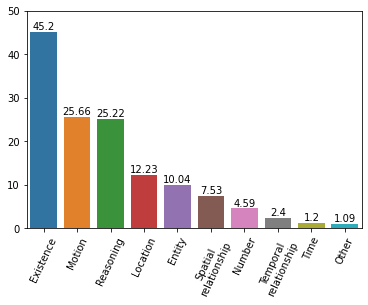

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt
# sns.set(style="whitegrid")
ax = sns.barplot(x=question_type.index,y=question_type)
plt.xticks(rotation=65)
plt.ylim(0,50)
ax.bar_label(ax.containers[0])
# plt.savefig("question-type.pdf")

#### prepare for sunflower plot

In [34]:
# with open("sunburst_plot/all_questions.txt","w") as f:
#     f.write("\n".join(df_qa["modified_question"])+"\n")
        
# for d in Domains:
#     with open(f"sunburst_plot/{d}_questions.txt","w") as f:
#         f.write("\n".join(df_qa[df_qa["domain"]==d]["modified_question"])+"\n")

In [39]:
# “is(are)”/”how many”/”where”/”how many”
# “Existence”/”Location”/”Number”

# check questions distribution in line with self-reported
qcount = [0,0,0]
for q in df_qa["modified_question"]:
    q = tokenizer(q)
    if q[0].lower() in {"is","are"}:
        qcount[0] += 1
    elif q[0].lower() == "where":
        qcount[1] += 1
    elif " ".join(q[:2]).lower() == "how many":
        qcount[2] += 1
        
print("is/are:{}; where:{}; how many:{}".\
      format(*list(np.round(np.array(qcount)*100/len(df_qa),FloatRound))))

is/are:24.13; where:7.21; how many:4.48


## Second phase

### Answer

/home/frank/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'answer count for each question')

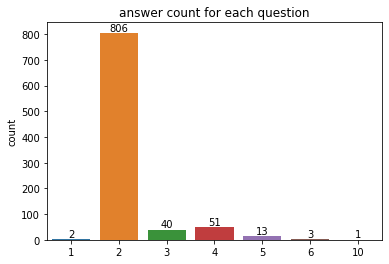

In [36]:
# answer per question
ax = sns.countplot(df_qa.apply(
    lambda x: len([b for a in eval(x['crowd_answers']) for b in a])+\
    len([b for a in eval(x['expert_answers']) for b in a]),axis=1)+1)
ax.bar_label(ax.containers[0])
plt.title("answer count for each question")

### answer based on

In [37]:
bases = [ans for que in df_qa["crowd_answer_based_on"] for worker in eval(que) for ans in worker] +\
[ans for que in df_qa["expert_answer_based_on"] for worker in eval(que) for ans in worker]
pd.value_counts(bases)/len(bases)

[scene]           0.893274
[audio, scene]    0.057399
[audio]           0.049327
dtype: float64

In [38]:
# for each domain answer based on
for d in Domains:
    dt = df_qa[df_qa["domain"]==d]
    bases = [ans for que in dt["crowd_answer_based_on"] for worker in eval(que) for ans in worker] +\
    [ans for que in dt["expert_answer_based_on"] for worker in eval(que) for ans in worker]
    print(d,"\n",pd.value_counts(bases)/len(bases),"\n")
del dt

Agriculture 
 [scene]           0.513761
[audio]           0.275229
[audio, scene]    0.211009
dtype: float64 

Human Survival 
 [scene]           0.951923
[audio, scene]    0.035256
[audio]           0.012821
dtype: float64 

Natural Disaster 
 [scene]           0.97861
[audio, scene]    0.02139
dtype: float64 

Geography 
 [scene]           0.944444
[audio, scene]    0.042484
[audio]           0.013072
dtype: float64 

Military 
 [scene]           0.850746
[audio]           0.084577
[audio, scene]    0.064677
dtype: float64 

